>>> 正在加载数据与缓存...
>>> 正在加载模型...
>>> 正在进行推理与特征提取...
>>> 开始绘图...
   [1/4] t-SNE 空间分布...


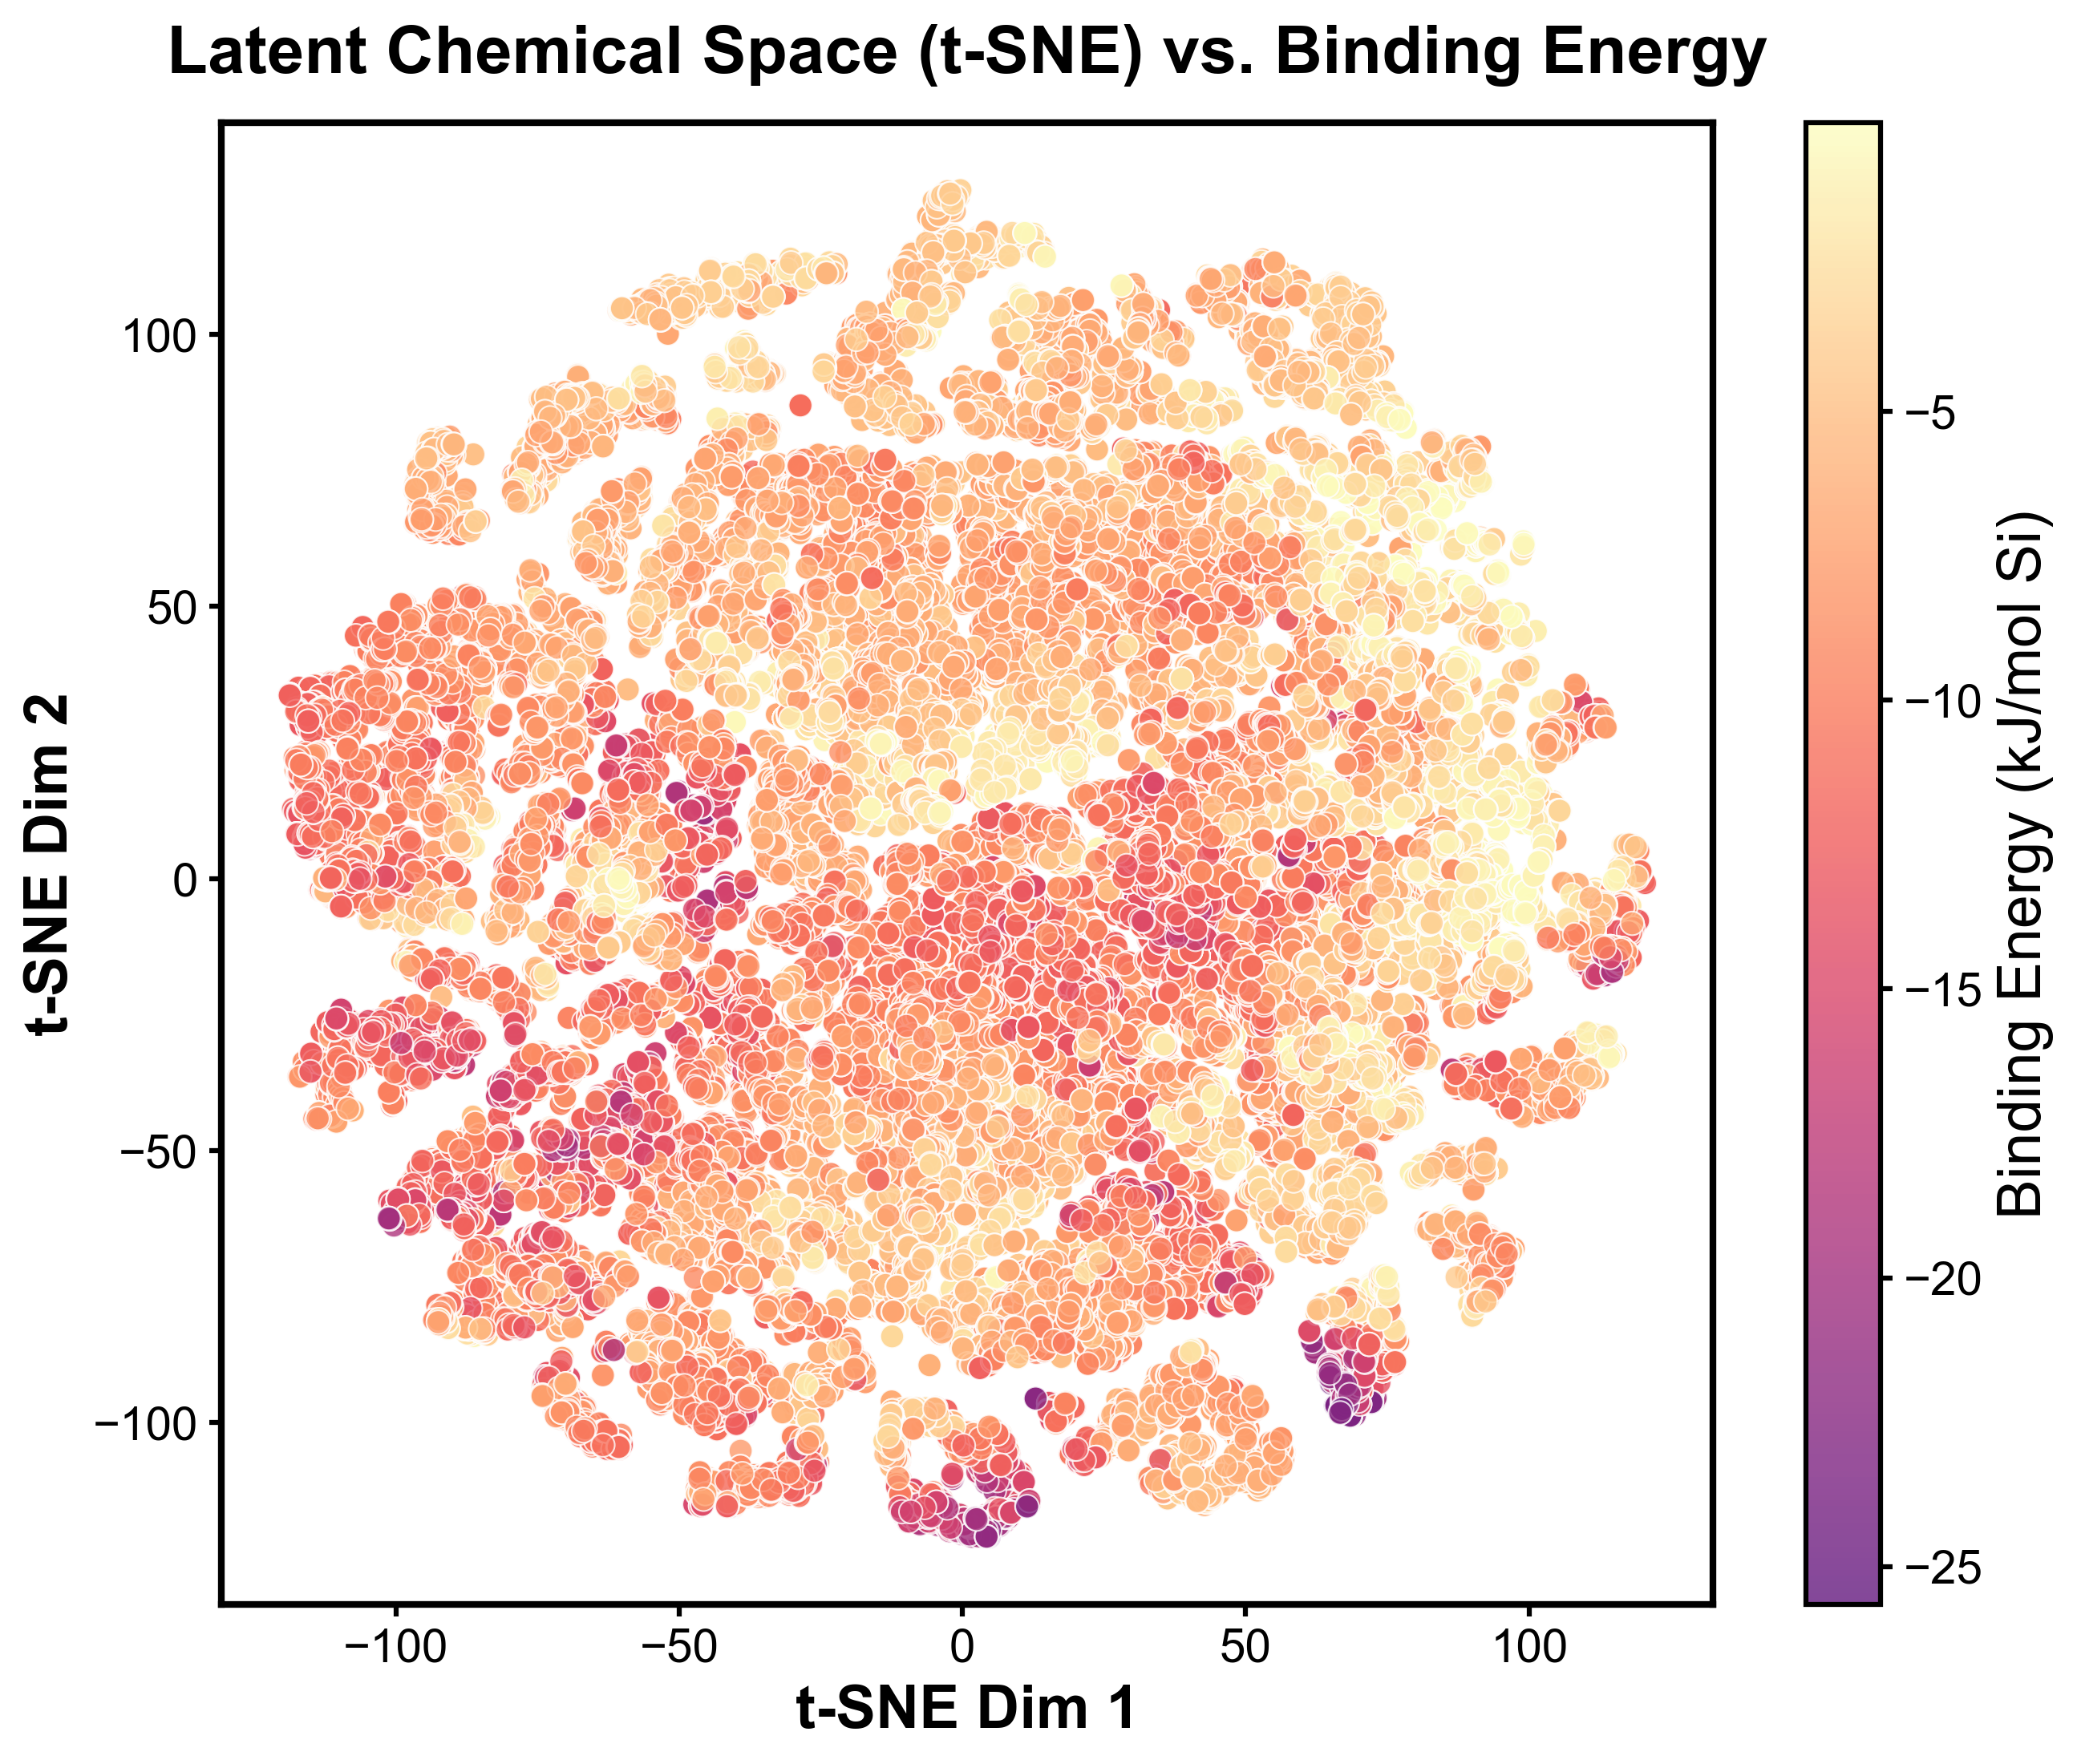

   [2/4] PCA 方差分析...


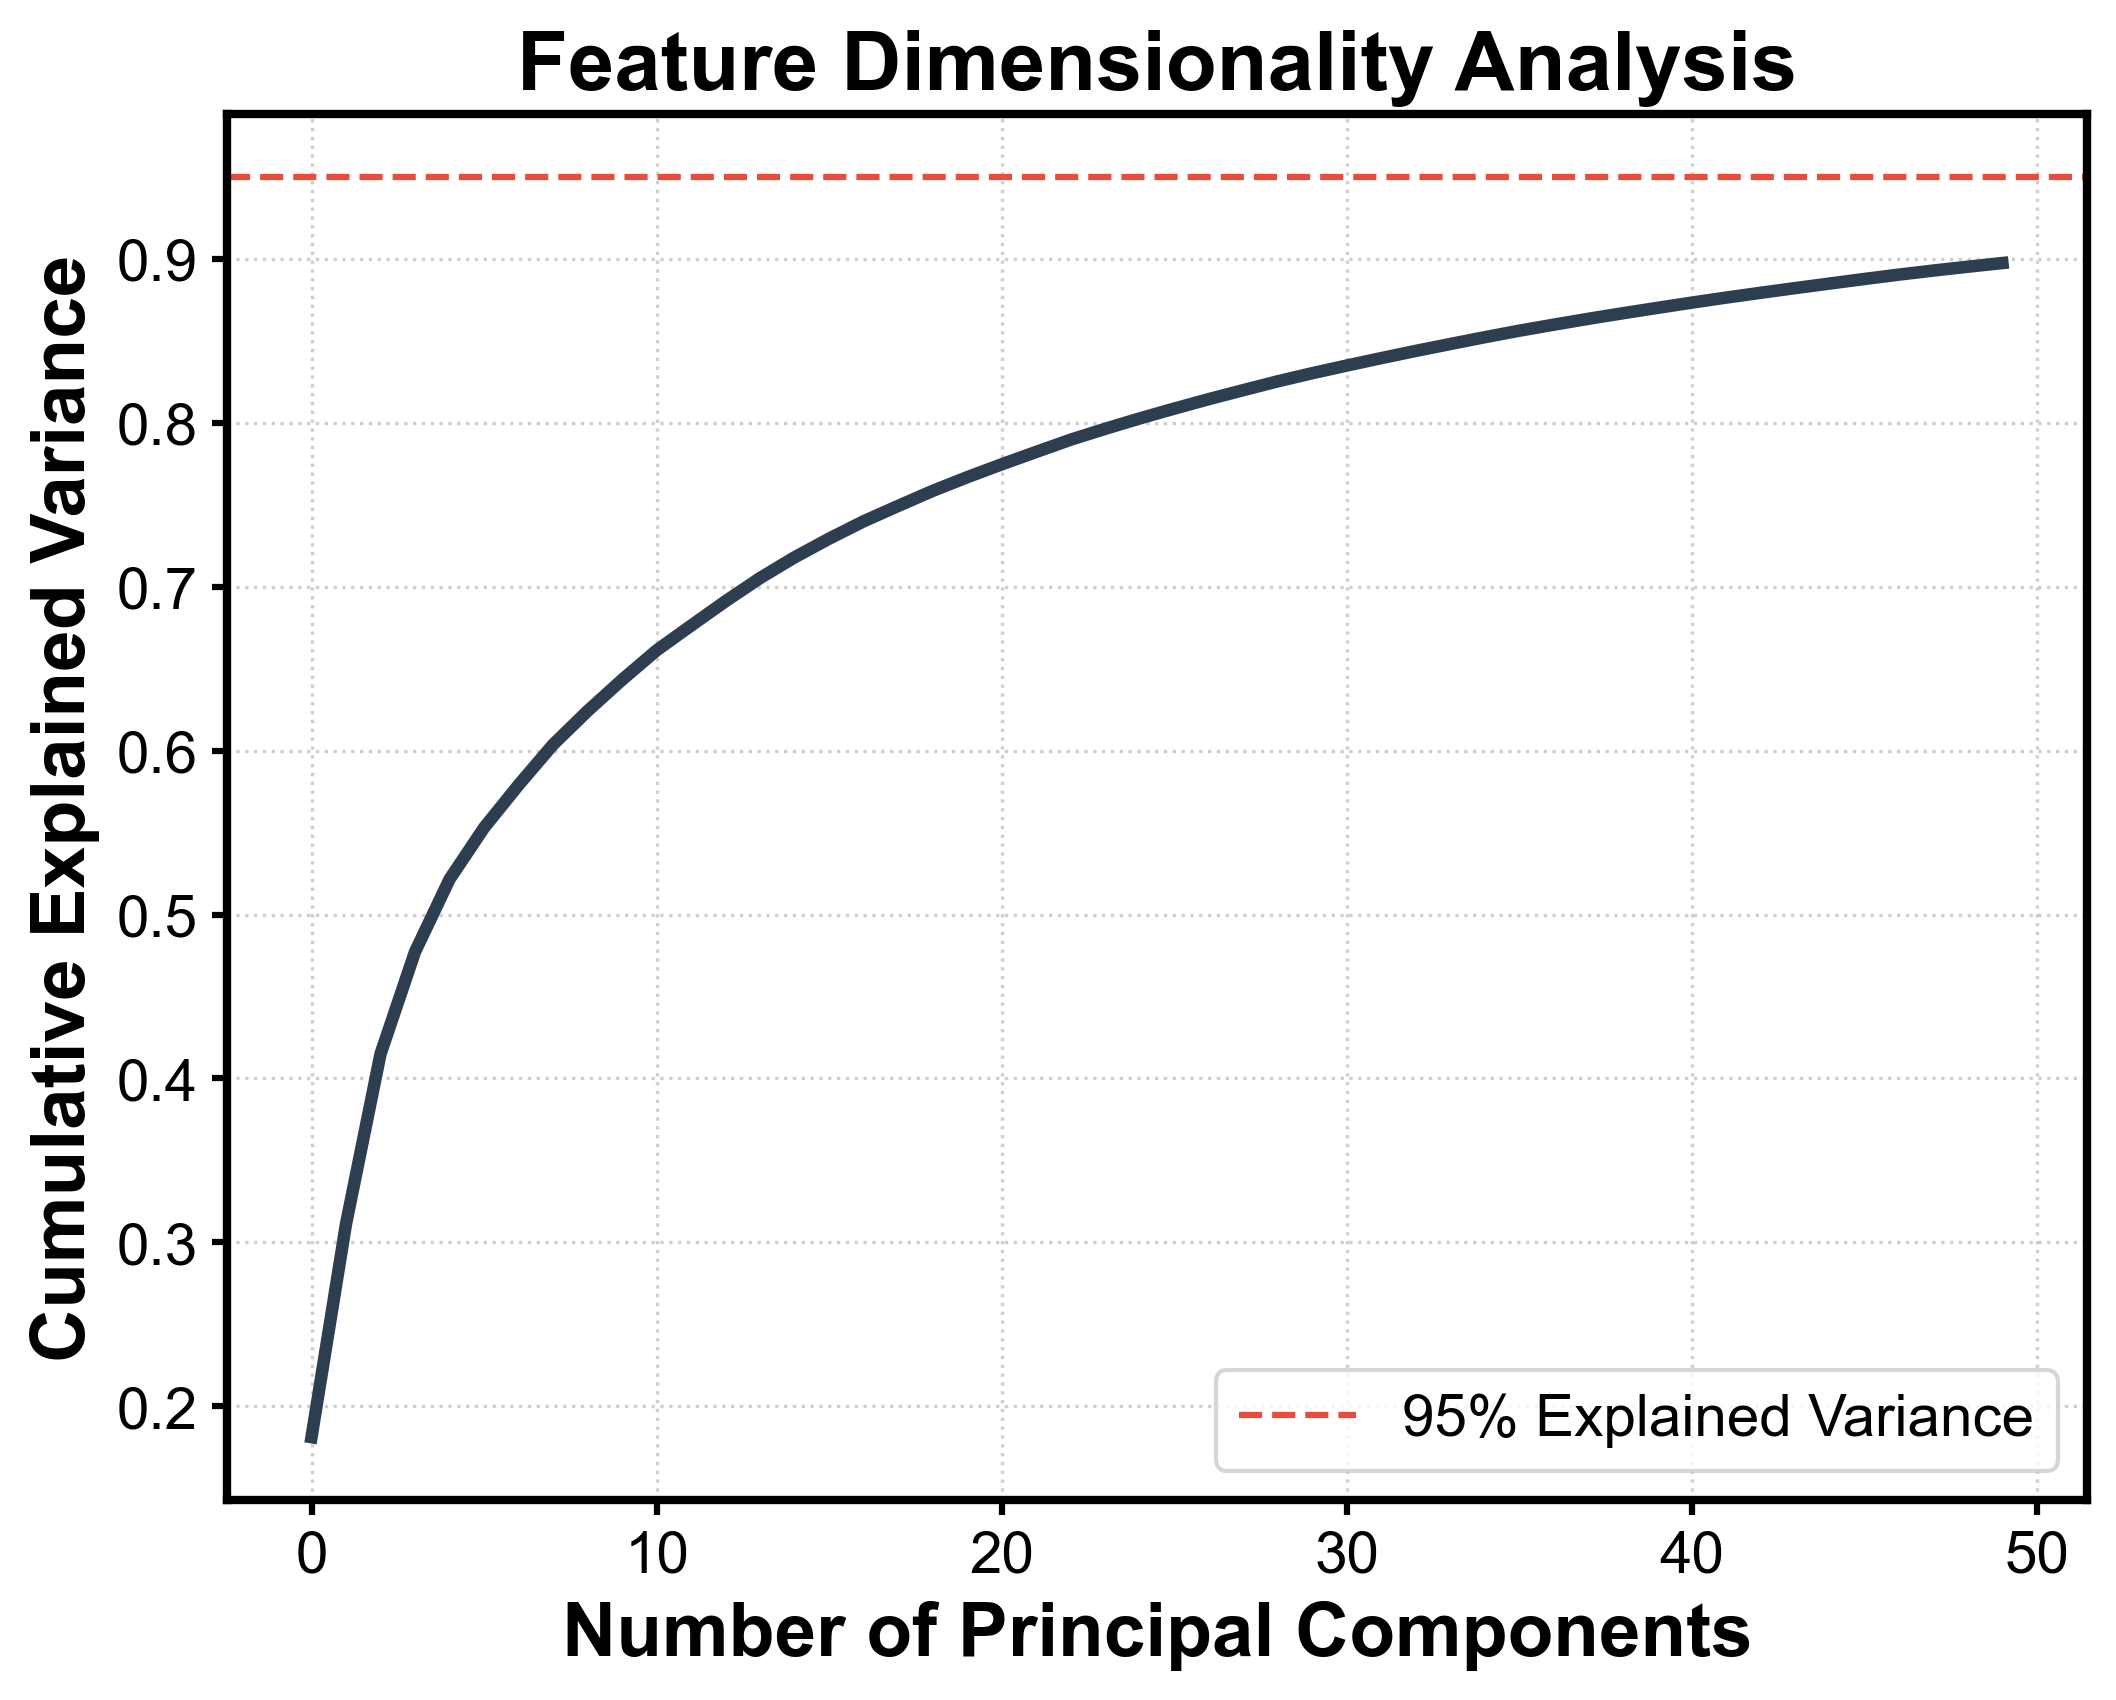

   [3/4] 描述符相关性热力图...


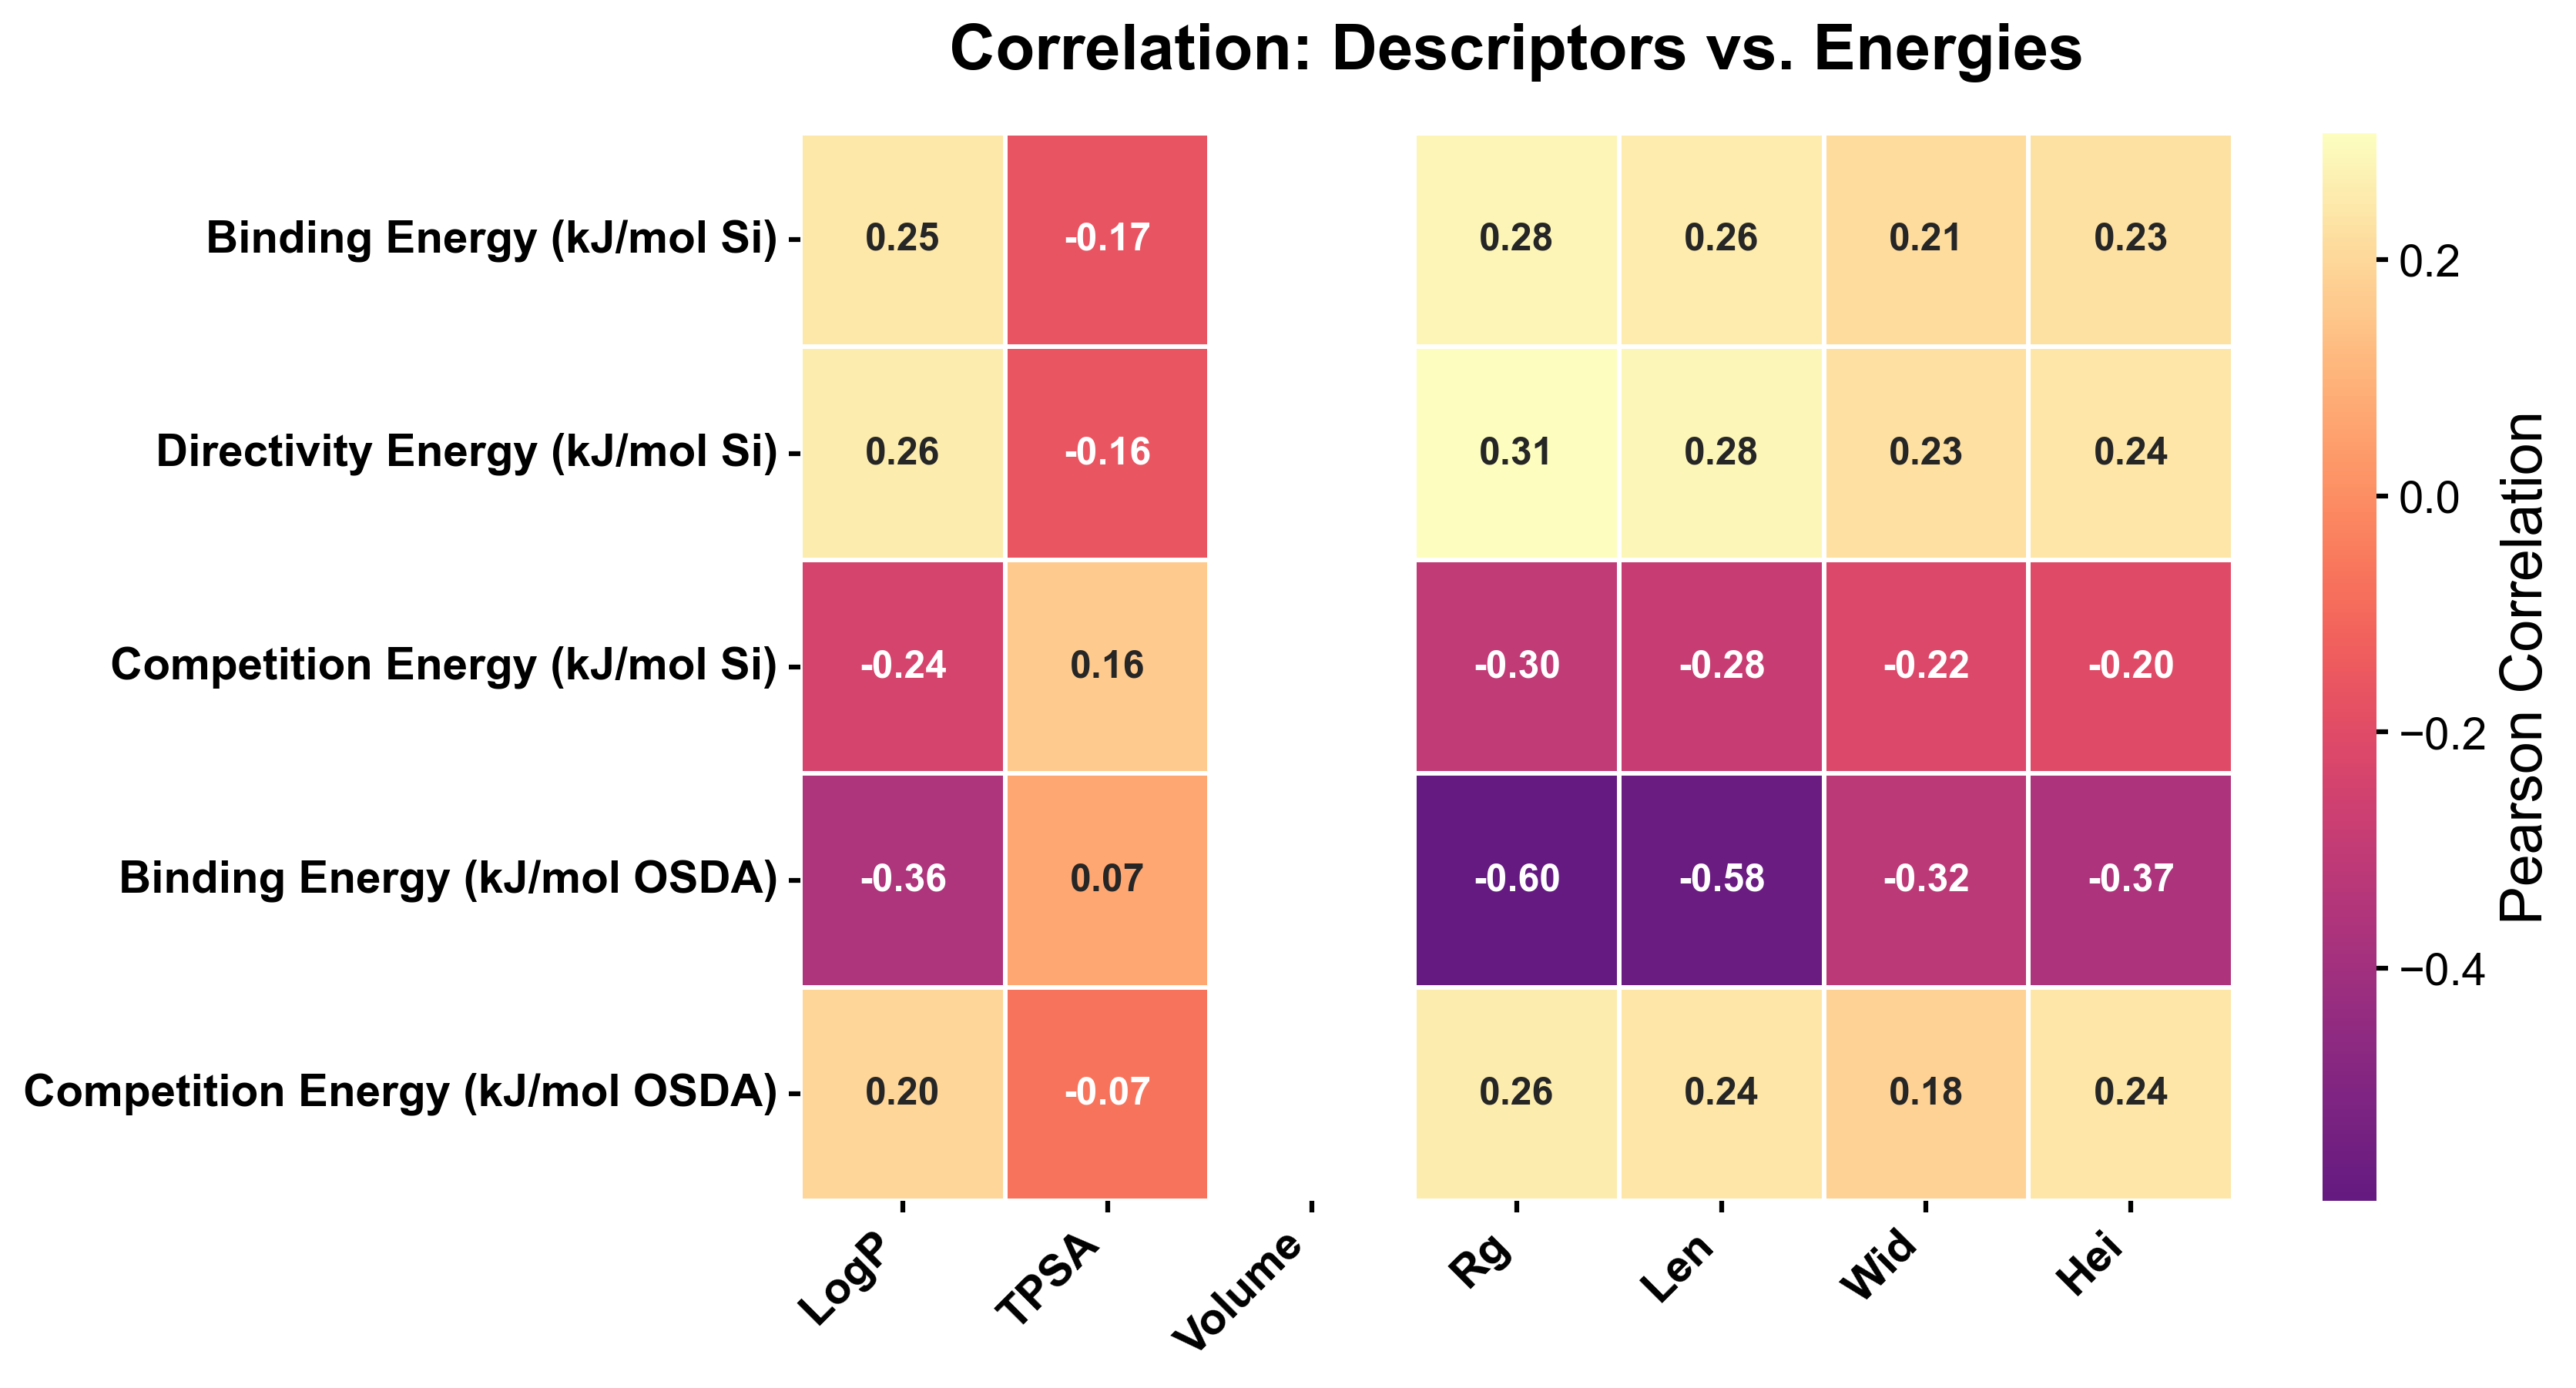

   [4/4] 预测精度对角图 (已修正文字位置)...


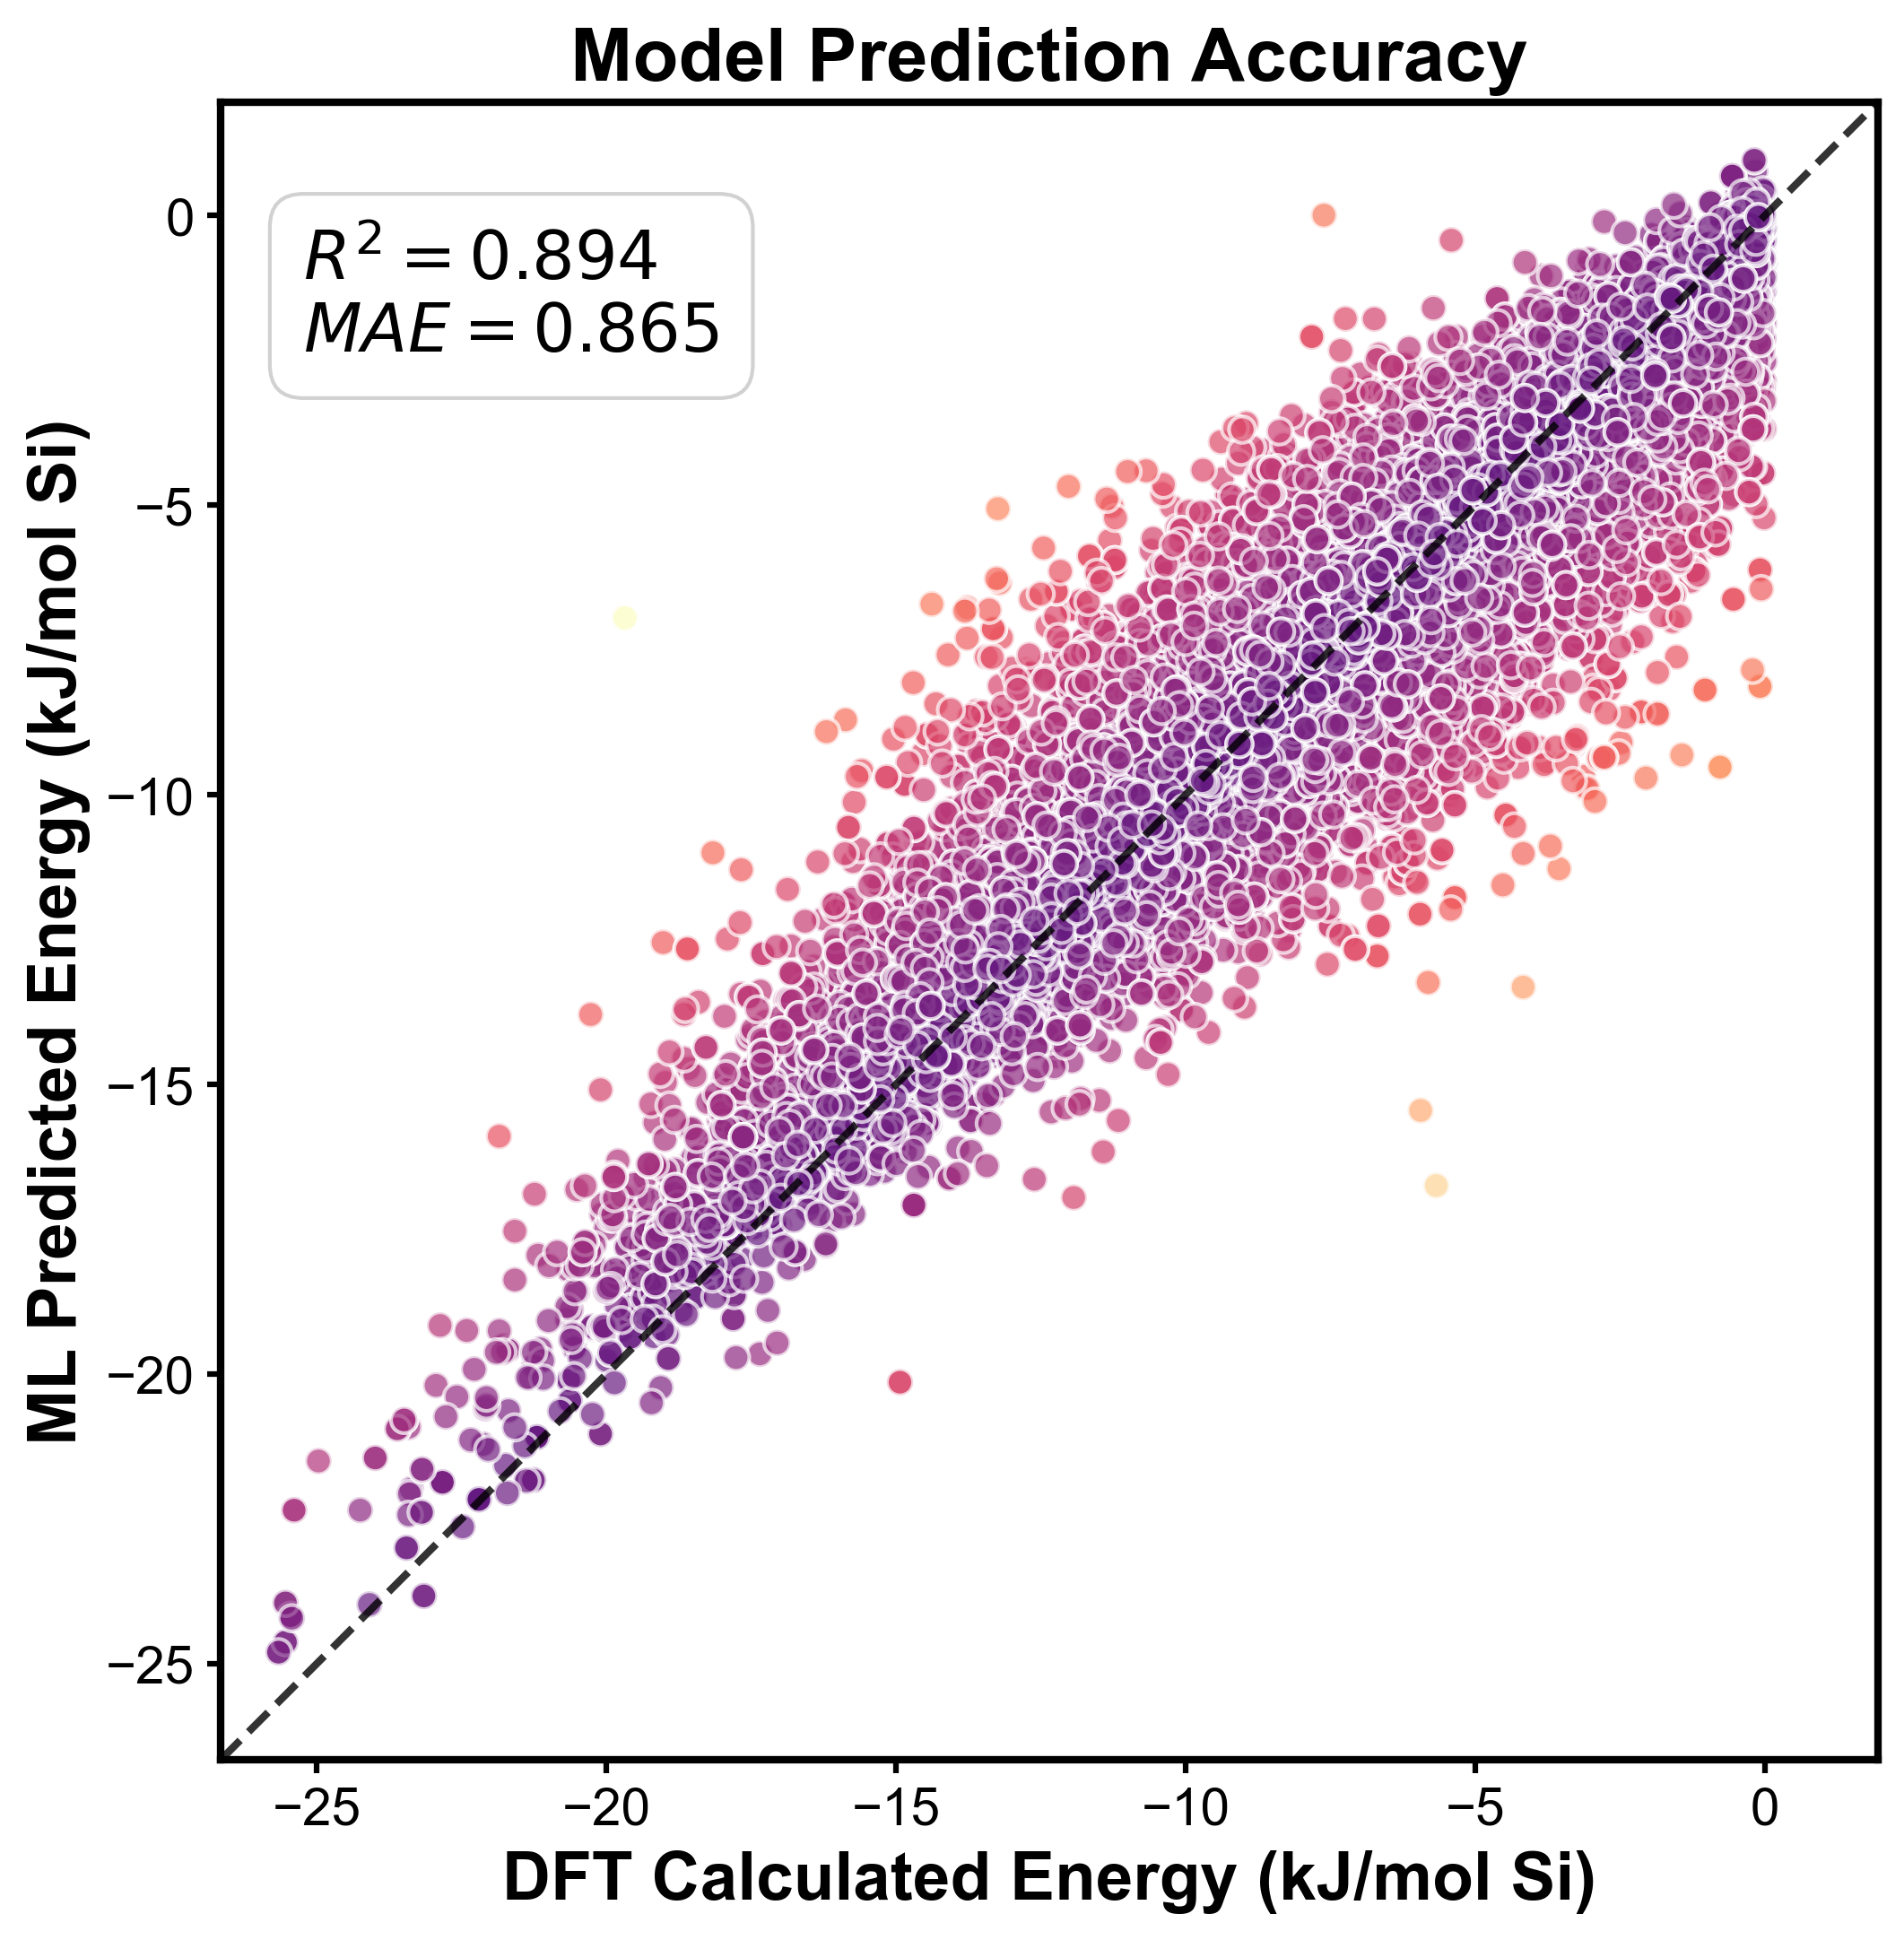


✅ 分析完成！所有图片已保存至: C:\Users\admin\Energymodel\2-9


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import pearsonr

class Config:
    BASE_PATH = r"./data"
    DATASET_PATH = os.path.join(BASE_PATH, "Energy_data.xlsx")
    PROCESSED_CACHE_PATH = r"./models/cached_graphs_box64_cleaned.pt"
    MODEL_PATH = r"./models/zeolite_3d_gnn_enriched_cleaned.pth"
    SAVE_DIR = r"./"

    
    BATCH_SIZE = 64 
    ATOM_EMBEDDING_DIM = 64
    HIDDEN_DIM = 128
    EMB_DIM_DEGREE = 8
    EMB_DIM_CHARGE = 8
    EMB_DIM_HYB = 8
    EMB_DIM_AROMATIC = 4
    EMB_DIM_CHIRAL = 4
    VOXEL_SIZE = 64
    VOXEL_RES = 0.5
    SIGMA = 0.5
    MIN_SAMPLES_PER_TOPO = 0
    
    TARGET_COLS = [
        'Binding Energy (kJ/mol Si)',
        'Directivity Energy (kJ/mol Si)',
        'Competition Energy (kJ/mol Si)',
        'Binding Energy (kJ/mol OSDA)',
        'Competition Energy (kJ/mol OSDA)'
    ]

os.makedirs(Config.SAVE_DIR, exist_ok=True)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.dpi': 300,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

def get_truncated_magma():
    cmap = plt.get_cmap('magma')
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.3, b=1.0),
        cmap(np.linspace(0.3, 1.0, 100))
    )
    return new_cmap

custom_cmap = get_truncated_magma()

def coords_to_voxel(coords, grid_size=32, res=0.5, sigma=0.5):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    limit = (grid_size * res) / 2.0
    mask = (coords[:, 0] > -limit) & (coords[:, 0] < limit) & \
           (coords[:, 1] > -limit) & (coords[:, 1] < limit) & \
           (coords[:, 2] > -limit) & (coords[:, 2] < limit)
    valid_coords = coords[mask]
    if len(valid_coords) == 0: return grid
    indices = ((valid_coords + limit) / res).astype(int)
    indices = np.clip(indices, 0, grid_size - 1)
    for idx in indices:
        grid[idx[0]-1:idx[0]+2, idx[1]-1:idx[1]+2, idx[2]-1:idx[2]+2] += 1.0
    return np.clip(grid, 0, 1.0)

class ZeoliteDataset(Dataset):
    def __init__(self, df, cache_data, target_scaler=None, props_scaler=None):
        super().__init__()
        self.target_scaler = target_scaler
        self.props_scaler = props_scaler
        mol_cache = cache_data['mol_cache']
        zeo_cache = cache_data['zeo_cache']
        self.mol_list = []
        self.zeo_list = []
        raw_y_list = []
        
        for idx, row in df.iterrows():
            cid = row['CID']
            topo = row['Topology Code']
            if cid in mol_cache and topo in zeo_cache:
                targets = row[Config.TARGET_COLS].values.astype(float)
                if not np.isnan(targets).any():
                    self.mol_list.append(mol_cache[cid])
                    self.zeo_list.append(zeo_cache[topo])
                    raw_y_list.append(targets)
        
        y_all = np.array(raw_y_list)
        if hasattr(self.target_scaler, 'mean_'):
            y_norm = self.target_scaler.transform(y_all)
        else:
            y_norm = self.target_scaler.fit_transform(y_all)
        self.y_list = [torch.tensor(y, dtype=torch.float) for y in y_norm]
        
        all_props = torch.cat([m.global_attr for m in self.mol_list], dim=0).numpy()
        if not hasattr(self.props_scaler, 'mean_'):
            self.props_scaler.fit(all_props)
        self.length = len(self.mol_list)

    def __len__(self): return self.length

    def __getitem__(self, idx):
        mol_data = self.mol_list[idx].clone()
        zeo_data = self.zeo_list[idx].clone()
        y = self.y_list[idx]
        
        props_raw = mol_data.global_attr.numpy()
        props_norm = self.props_scaler.transform(props_raw)
        mol_data.global_attr = torch.tensor(props_norm, dtype=torch.float)

        mol_coords = mol_data.pos.numpy()
        if hasattr(mol_data, 'pos_variants'):
            mol_coords = mol_data.pos_variants[0].numpy()
            del mol_data.pos_variants
        zeo_voxel_coords = zeo_data.pos_super.numpy() if hasattr(zeo_data, 'pos_super') else zeo_data.pos.numpy()
        if hasattr(zeo_data, 'pos_super'): del zeo_data.pos_super 
        mol_data.pos = torch.tensor(mol_coords, dtype=torch.float)
        
        grid_mol = coords_to_voxel(mol_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        grid_zeo = coords_to_voxel(zeo_voxel_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        voxel_tensor = torch.tensor(np.stack([grid_mol, grid_zeo], axis=0), dtype=torch.float)
        
        return mol_data, zeo_data, voxel_tensor, y, torch.tensor(props_raw, dtype=torch.float)

    @staticmethod
    def gpu_collate(batch):
        return (Batch.from_data_list([i[0] for i in batch]),
                Batch.from_data_list([i[1] for i in batch]),
                torch.stack([i[2] for i in batch]),
                torch.stack([i[3] for i in batch]),
                torch.stack([i[4] for i in batch]))

class Voxel3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 16, 3, padding=1); self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1); self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d(2)
        self.fc = nn.Linear(64 * 8 * 8 * 8, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return F.relu(self.fc(x.view(x.size(0), -1)))

class DualBranchGNN_Analysis(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_atom = nn.Embedding(120, Config.ATOM_EMBEDDING_DIM)
        self.emb_degree = nn.Embedding(12, Config.EMB_DIM_DEGREE)
        self.emb_charge = nn.Embedding(15, Config.EMB_DIM_CHARGE)
        self.emb_hyb = nn.Embedding(8, Config.EMB_DIM_HYB)
        self.emb_aromatic = nn.Embedding(2, Config.EMB_DIM_AROMATIC)
        self.emb_chiral = nn.Embedding(4, Config.EMB_DIM_CHIRAL)
        
        total_emb = Config.ATOM_EMBEDDING_DIM + Config.EMB_DIM_DEGREE + Config.EMB_DIM_CHARGE + Config.EMB_DIM_HYB + Config.EMB_DIM_AROMATIC + Config.EMB_DIM_CHIRAL
        self.mol_conv1 = GCNConv(total_emb + 1, Config.HIDDEN_DIM)
        self.mol_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.zeo_conv1 = GCNConv(total_emb, Config.HIDDEN_DIM)
        self.zeo_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.voxel_cnn = Voxel3DCNN()
        self.global_encoder = nn.Sequential(nn.Linear(17, 64), nn.ReLU(), nn.Linear(64, Config.HIDDEN_DIM), nn.BatchNorm1d(Config.HIDDEN_DIM), nn.ReLU())
        
        self.head_proj = nn.Sequential(nn.Linear(Config.HIDDEN_DIM*4, 512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, 256), nn.ReLU())
        self.head_out = nn.Linear(256, len(Config.TARGET_COLS))

    def _embed(self, x):
        return torch.cat([self.emb_atom(x[:,0]), self.emb_degree(x[:,1]), self.emb_charge(x[:,2]), self.emb_hyb(x[:,3]), self.emb_aromatic(x[:,4]), self.emb_chiral(x[:,5])], dim=1)

    def forward(self, mol, zeo, vox, return_features=False):
        xm = global_mean_pool(F.relu(self.mol_conv2(F.relu(self.mol_conv1(torch.cat([self._embed(mol.x), mol.x_charge], 1), mol.edge_index, edge_weight=mol.edge_weight)), mol.edge_index, edge_weight=mol.edge_weight)), mol.batch)
        xz = global_mean_pool(F.relu(self.zeo_conv2(F.relu(self.zeo_conv1(self._embed(zeo.x), zeo.edge_index)), zeo.edge_index)), zeo.batch)
        xv = self.voxel_cnn(vox)
        xg = self.global_encoder(mol.global_attr.squeeze(1) if mol.global_attr.dim()==3 else mol.global_attr)
        
        feat = self.head_proj(torch.cat([xm, xz, xg, xv], 1))
        out = self.head_out(feat)
        return (out, feat) if return_features else out

def main_analysis():
    torch.serialization.add_safe_globals([Data, Batch, Dataset])
    
    print("Loading")
    df = pd.read_excel(Config.DATASET_PATH, engine='openpyxl')
    topo_counts = df['Topology Code'].value_counts()
    valid_topos = topo_counts[topo_counts >= Config.MIN_SAMPLES_PER_TOPO].index
    df_filtered = df[df['Topology Code'].isin(valid_topos)].reset_index(drop=True)
    
    cache_data = torch.load(Config.PROCESSED_CACHE_PATH, weights_only=False)
    
    idx = list(range(len(df_filtered)))
    train_idx, _ = train_test_split(idx, train_size=0.8, random_state=42)
    dummy = ZeoliteDataset(df_filtered.iloc[train_idx].reset_index(drop=True), cache_data, StandardScaler(), StandardScaler())
    
    dataset = ZeoliteDataset(df_filtered, cache_data, dummy.target_scaler, dummy.props_scaler)
    loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=ZeoliteDataset.gpu_collate)
    
    print("Loading Models")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualBranchGNN_Analysis().to(device)
    
    state = torch.load(Config.MODEL_PATH, map_location=device)
    new_state = {}
    for k, v in state.items():
        if "head.0." in k: new_state[k.replace("head.0.", "head_proj.0.")] = v
        elif "head.3." in k: new_state[k.replace("head.3.", "head_proj.3.")] = v
        elif "head.5." in k: new_state[k.replace("head.5.", "head_out.")] = v
        else: new_state[k] = v
    model.load_state_dict(new_state, strict=False)
    model.eval()
    
    print("Inference and Feature Extraction")
    preds, trues, feats, props = [], [], [], []
    with torch.no_grad():
        for m, z, v, y, p in loader:
            m, z, v = m.to(device), z.to(device), v.to(device)
            out, f = model(m, z, v, return_features=True)
            preds.append(out.cpu().numpy()); trues.append(y.numpy())
            feats.append(f.cpu().numpy()); props.append(p.squeeze(1).numpy())
            
    preds_real = dummy.target_scaler.inverse_transform(np.vstack(preds))
    trues_real = dummy.target_scaler.inverse_transform(np.vstack(trues))
    features = np.vstack(feats)
    props_raw = np.vstack(props)
    
    prop_names = ['LogP', 'TPSA', 'Rotatable', 'H_Acc', 'H_Don', 'Volume', 'Charge', 
                  'Rg', 'Eig1', 'Eig2', 'Eig3', 'Anisotropy', 'Sphericity', 'Linearity', 'Len', 'Wid', 'Hei']
    
    print("Start drawing")
    
    # --- Analysis 1: t-SNE ---
    print("   [1/4] t-SNE")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    X_emb = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(X_emb[:,0], X_emb[:,1], c=trues_real[:,0], cmap=custom_cmap, s=50, alpha=0.8, edgecolors='w', linewidth=0.5)
    cbar = plt.colorbar(sc, label='Binding Energy (kJ/mol Si)')
    cbar.outline.set_linewidth(1.5)
    plt.title('Latent Chemical Space (t-SNE) vs. Binding Energy', fontweight='bold', pad=15)
    plt.xlabel('t-SNE Dim 1', fontweight='bold'); plt.ylabel('t-SNE Dim 2', fontweight='bold')
    for spine in plt.gca().spines.values(): spine.set_linewidth(2)
    plt.savefig(os.path.join(Config.SAVE_DIR, 'Analysis_1_tSNE.png'), dpi=300)
    plt.show()

    # --- Analysis 1b: PCA Variance ---
    print("   [2/4] PCA")
    pca = PCA(n_components=50).fit(features)
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3, color='#2c3e50')
    plt.axhline(y=0.95, color='#e74c3c', linestyle='--', label='95% Explained Variance')
    plt.xlabel('Number of Principal Components', fontweight='bold')
    plt.ylabel('Cumulative Explained Variance', fontweight='bold')
    plt.title('Feature Dimensionality Analysis', fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    for spine in plt.gca().spines.values(): spine.set_linewidth(2)
    plt.savefig(os.path.join(Config.SAVE_DIR, 'Analysis_1b_PCA.png'), dpi=300)
    plt.show()
    
    # --- Analysis 2: Correlation Heatmap ---
    print("   [3/4] Descriptor Correlation Heat Map")
    data_corr = {name: trues_real[:, i] for i, name in enumerate(Config.TARGET_COLS)}
    sel_props = ['LogP', 'TPSA', 'Volume', 'Rg', 'Len', 'Wid', 'Hei']
    for p in sel_props: data_corr[p] = props_raw[:, prop_names.index(p)]
    
    df_corr = pd.DataFrame(data_corr)
    corr_mat = df_corr.corr().loc[Config.TARGET_COLS, sel_props]
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap=custom_cmap, cbar_kws={'label': 'Pearson Correlation'},
                linewidths=1, linecolor='white', annot_kws={"size": 12, "weight": "bold"})
    plt.title('Correlation: Descriptors vs. Energies', fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontweight='bold'); plt.yticks(fontweight='bold')
    plt.savefig(os.path.join(Config.SAVE_DIR, 'Analysis_2_Heatmap.png'), dpi=300)
    plt.show()
    
    # --- Analysis 3: Parity Plot  ---
    print("   [4/4] Predictive accuracy diagonal ")
    y_true, y_pred = trues_real[:, 0], preds_real[:, 0]
    r2, mae = r2_score(y_true, y_pred), mean_absolute_error(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, c=np.abs(y_true - y_pred), cmap=custom_cmap, alpha=0.7, s=50, edgecolors='w')
    
    vmin, vmax = min(y_true.min(), y_pred.min()) - 1, max(y_true.max(), y_pred.max()) + 1
    plt.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=2, alpha=0.8)
    
    ax = plt.gca()
    plt.text(0.05, 0.85, f'$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$', 
             transform=ax.transAxes, fontsize=18, fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='#cccccc', boxstyle='round,pad=0.5'))
    
    plt.xlabel('DFT Calculated Energy (kJ/mol Si)', fontweight='bold')
    plt.ylabel('ML Predicted Energy (kJ/mol Si)', fontweight='bold')
    plt.title('Model Prediction Accuracy', fontweight='bold')
    plt.xlim(vmin, vmax); plt.ylim(vmin, vmax)
    ax.set_aspect('equal')
    for spine in ax.spines.values(): spine.set_linewidth(2)
    plt.savefig(os.path.join(Config.SAVE_DIR, 'Analysis_3_Parity.png'), dpi=300)
    plt.show()

    print(f"\nchart saved: {Config.SAVE_DIR}")

if __name__ == "__main__":
    main_analysis()